In [77]:
#approx run time: 18 minutes
#check what version of python you're using - I think mine (AER) is 3.8.5
from platform import python_version
print(python_version())

#importing libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.wcs import WCS
from astropy.nddata import Cutout2D

import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

3.8.13


In [78]:
#image plotting in python
def implot(data, w, wcscond, vmax_p, vmin_p):
    fig = plt.figure()
    
    if  wcscond == True:
        fig.add_subplot(111, projection=w)
    else:
        fig.add_subplot(111)
    
    #for christmas turn on GnRd
    #plt.cm.get_cmap('Blues', 6) is another option
    #can also use RdBu...
    #otherwise just use plt.cm.viridis b/c it works
    plt.imshow(data, origin='lower', cmap=plt.cm.viridis, vmin =vmin_p, vmax=vmax_p)
    plt.colorbar()
    plt.xlabel('RA')
    plt.ylabel('Dec')

    
# #finding the path to every fits images in a directory - needs more work, ignore for now
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #using s.lower() include uppercase names
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names

#setting up a new fits file to be saved and viewed in DS9
#primarily to save the image we reprojected, but can also be used to save the convolved images
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data usually from some FITS format image
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. If you want to name it something else, it will get string split at the / character, and the func only takes the last element of that splitting. So you can do something like ' /...'
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_'). I usually append some extra info to the filename, though that can be flexible
    '''

    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])

    #saving the file
    new_filename = name.split('/')[-1]  #grabs the file name we were using from before
    hdul.writeto(save_path+new_filename, overwrite=True)

    return (save_path+new_filename)



In [79]:
#reading in file paths and data, change as you like
# path_data = 'fitting_withOI_rms/*cutout*656shifted*'
path_data = '../inanna_runs/cutout_fluxcutoff/*.fits'
files_data = [i.replace('\\', '/') for i in glob.glob(path_data+'*')[-3:]] #change this to just pick out just the nir images (126, 128, 164)
hdu_list = [fits.open(i) for i in files_data] 

print(path_data, files_data)

#grabbing data and headers
count = 0 #I always have count here because sometimes images are formatted inconsistently or indexed differently
hdu_data_list = []
hdu_header_list = []

for hdu_data in hdu_list:
    #reading in data for general use and header for wcs
    hdu_data_list.append(hdu_data[0].data)
    hdu_header_list.append(hdu_data[0].header)

    count += 1
    
w = WCS(hdu_header_list[0]) #I picked 0 arbitrarily, it shouldn't since they're aligned
wcs_header = w.to_header()

#removing nans from the data, repacking it for convenient use 
f2 = np.nan_to_num(hdu_data_list[0])
f3 = np.nan_to_num(hdu_data_list[1])
f4 = np.nan_to_num(hdu_data_list[2])
nir_flux = np.array([f2, f3, f4])

#list of wavelengths for each filter being used ... not sure how to code this automatically
lam_val = 1e-4 * np.array([0.656, 1.26, 1.28, 1.64]) #in CGS
lam_arr = 1e-4 * np.array([0.656, 1.26, 1.28, 1.64]) #in CGS
# lam_arr = np.array([lam*np.ones((nir_flux[0].shape[0], nir_flux[0].shape[1])) for lam in lam_val], dtype='uint8')

../inanna_runs/cutout_fluxcutoff/*.fits ['../inanna_runs/cutout_fluxcutoff/nonlincutout_656shifted_newcal_0p1e-17_1_26_mic.fits', '../inanna_runs/cutout_fluxcutoff/nonlincutout_656shifted_newcal_0p1e-17_1_28_mic.fits', '../inanna_runs/cutout_fluxcutoff/nonlincutout_656shifted_newcal_0p1e-17_1_64_mic.fits']


In [95]:
#setting some initial values for fitting extinction and continuum
R_Fe = 2.6
T = np.linspace(500, 10000, 10) #example list of temperatures
# ratio_list = [[0.5, np.nan, 1], [0.87, np.nan, 1], [1.2, np.nan, 1], [2.0, np.nan, 1]] #some typical [FeII] ratios
ratio_list = [[1.2, np.nan, 1.4], [1.0, np.nan, 1.7], [1.0, np.nan, 2.5], [1.2, np.nan, 0.5], [1.2, np.nan, 0.8]] #some measured ratios

In [96]:
#constants and function for planck's law
h = 6.626e-27 #CGS units, ergs*sec
c = 2.998e10 #CGS units, cm/s
k_B = 1.38e-16 #CGS, ergs/K

def B_lam(input_arr, temp=2000):
    lam = input_arr
    return 2. * h * c**2. / lam**5. * 1. / (np.exp((h * c) / (lam*k_B*temp)) - 1.)

# functions below to model Av(T), scale factor for blackbody emission, intensity(1.64 mic), and intensity(1.26 mic)
y_arr = [0.47245, 0.77307, 0.78015, 0.85001] #this is used in general for our equations

#for Av
def Av_func(pix_flux, T):
    f2 = pix_flux[0]
    f4 = pix_flux[2]
    
    #unlogged equation
    # equ_nolog = ((f2 * (1. - (B_lam(lam_arr[1],T) - B_lam(lam_arr[3],T)) / (B_lam(lam_arr[1], T) - R_Fe*B_lam(lam_arr[3],T))))
    #         / (f4 * B_lam(lam_arr[1], T) * (1. - R_Fe) / ((B_lam(lam_arr[1], T) - R_Fe*B_lam(lam_arr[3], T)))) )
    equ_nolog = ((f2 * B_lam(lam_arr[3], T)) / (f4 * B_lam(lam_arr[1], T)))

    base = y_arr[1]/y_arr[3]
    Av = np.log(equ_nolog) / np.log(base) #logging to make Av
    
    return Av

#scale for blackbody continuum
def C_func(pix_flux, T):
    f2 = pix_flux[0]
    f4 = pix_flux[2]
    
    C = (f2/y_arr[1]**Av_func(pix_flux, T)
           - R_Fe*f4/y_arr[3]**Av_func(pix_flux, T)) / (B_lam(lam_arr[1], T) - R_Fe*B_lam(lam_arr[3], T))
    return C

#[FeII] line intensityintensity at 1.64 mic
def f_Fe_func(pix_flux, T):
    f2 = pix_flux[0]
    f4 = pix_flux[2]
   
    fFe = (f4/y_arr[3]**Av_func(pix_flux, T)*B_lam(lam_arr[1], T) 
           - f2/y_arr[1]**Av_func(pix_flux, T)*B_lam(lam_arr[3], T)) / (B_lam(lam_arr[1], T) - R_Fe*B_lam(lam_arr[3], T))
    return fFe

#HI line intensityintensity at 1.28 mic
def fH_func(pix_flux, T):
    f3 = pix_flux[1]
    
    fH = f3/y_arr[2]**Av_func(pix_flux, T) - C_func(pix_flux, T) * B_lam(lam_arr[2], T)
    return fH

#the general solution I use, choose your output is made to be used in a faster minimize or least squares routine
#a few examples are given (chi^2, diff, rms, etc)
def scatt_func(input_arr, I1, I2, I3):   
    T = input_arr
    I126, I128, I164 = I1, I2, I3
    B_lam_arr = [B_lam(lam_val[1], T), B_lam(lam_val[2], T), B_lam(lam_val[3], T)] #computing once so the calculation is not repeated
    
    equ_nolog = ((I126 * B_lam_arr[2]) / (I164 * B_lam_arr[0]))
    base = y_arr[1]/y_arr[3]
    Av = np.log(equ_nolog) / np.log(base) #this is Av
    fFe = (I164/y_arr[3]**Av*B_lam_arr[0] - I126/y_arr[1]**Av*B_lam_arr[2]) / (B_lam_arr[0]- R_Fe*B_lam_arr[2])
    C = (I126/y_arr[1]**Av - R_Fe*I164/y_arr[3]**Av) / (B_lam_arr[0] - R_Fe*B_lam_arr[2])
    fH = I128/y_arr[2]**Av - C * B_lam_arr[1]
    
    #some print statements if you want to check anything
#     print(T, I126, I128, I164, B_lam_arr, Av, fFe, C, fH)
#     print(np.array([(R_Fe * fFe + C*B_lam_arr[0]) * y_arr[1]**Av,
#         (fH + C*B_lam_arr[1]) * y_arr[2]**Av,
#         (fFe + C*B_lam_arr[2]) * y_arr[3]**Av ]))
    
    obs_intens = np.array([I126, I128, I164]) #should be same as pix_flux as defined in loop, a line flux at each pixel...
    theory_intens = np.array([(R_Fe * fFe + C*B_lam_arr[0]) * y_arr[1]**Av,
        (fH + C*B_lam_arr[1]) * y_arr[2]**Av,
        (fFe + C*B_lam_arr[2]) * y_arr[3]**Av ])
#     n_obs = len(obs_intens) #if you want to test the return options
    
    #return obs_intens - theory_intens
    #return np.sqrt(np.sum((obs_intens - theory_intens)**2.)) / (n_obs -1.) #technically not accurate, but it does provide different scaling 
    return np.sqrt(np.sum((obs_intens - theory_intens)**2./(obs_intens)**2.)) 

Text(0.5, 0, 'T (K)')

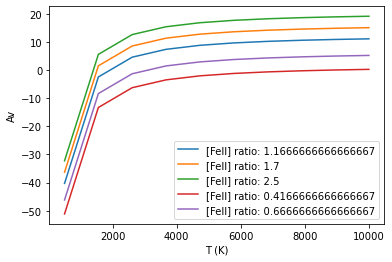

In [97]:
#checking behavior of T using Av_func
#changes confirmed here need to be changed in: Av_func, scatt_func, and latter half of next cell (where Av(T) is computed post-solving)

#computing example Avs and then plotting
for ratio in ratio_list:
    Av = [Av_func(ratio, i) for i in T]
    plt.plot(T, Av, label='[FeII] ratio: '+str(ratio[2]/ratio[0]))

# plt.ylim(0,)
plt.legend(loc='best')
plt.ylabel('Av')
plt.xlabel('T (K)')

Text(0, 0.5, 'Av')

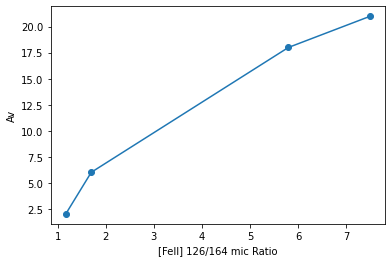

In [91]:
# plt.scatter([0.5, 0.87, 1.2, 2.0], [5, 11, 15, 21])
# plt.plot([0.5, 0.87, 1.2, 2.0], [5, 11, 15, 21])

#from the measurements above, to check...
plt.scatter([1.17, 1.7, 5.8, 7.5], [2, 6, 18, 21])
plt.plot([1.17, 1.7, 5.8, 7.5], [2, 6, 18, 21])
plt.xlabel('[FeII] 126/164 mic Ratio')
plt.ylabel('Av')


In [74]:
from scipy.optimize import least_squares

#initial guess
T_guess = 1000
# R_Fe = 2.6
# R_Fe_list = [1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]
R_Fe_list = [2.6]

#looping through R_Fe to solve for temperatures
fit_arr = [[] for x in range(nir_flux[0].shape[0] * nir_flux[0].shape[1])]
for R_Fe in R_Fe_list:
    count = 0
    
    #looping through x-axis values
    for i in range(nir_flux[0].shape[0]):
        #looping through y-axis values
        for j in range(nir_flux[0].shape[1]):
            pix_flux = np.array([nir_flux[0][i, j], nir_flux[1][i, j], nir_flux[2][i, j]]) #intensity to be fit
            try:
    #           #now for least squares fit, I set gtol very low but it could be slightly more flexible
                res = least_squares(scatt_func, T_guess, args=(pix_flux[0], pix_flux[1], pix_flux[2]), ftol=2e-25) #, gtol=1e-40, max_nfev=500, bounds=(0,np.inf)) #other params
                T_fit = res.x[0]
                fit_arr[count] = [i, j, T_fit]

            except Exception as e2: #in case no fit can be found, can check why here
    #                 print('type is:', e2.__class__.__name__) 
    #                 print('no fit found')
                fit_arr[count] = (i, j, np.nan)
            count +=1


    #setting up array of equation variables for saving
    #probably faster ways of doign this, but I found this easier to test
    f_H_arr = np.zeros_like(nir_flux[0])
    f_Fe_arr = np.zeros_like(nir_flux[0])
    C_arr = np.zeros_like(nir_flux[0])
    A_V_arr = np.zeros_like(nir_flux[0])
    T_arr = np.zeros_like(nir_flux[0])
    rms_arr = np.zeros_like(nir_flux[0])

    #reorganizing data in 2d array
    for line in fit_arr:
        T = line[2]

        #indices
        i = line[0]
        j = line[1]
        T_arr[i][j] = T

        #using indices, T to compute...
        I126, I128, I164 = np.array([nir_flux[0][i, j], nir_flux[1][i, j], nir_flux[2][i, j]]) 
        B_lam_arr = [B_lam(lam_val[1], T), B_lam(lam_val[2], T), B_lam(lam_val[3], T)]
        
        #below, the fit param (Av, C, fFe, fH) are calculated based on temperature, then stored in their respective _arr list
        equ_nolog = ((I126 * B_lam(lam_arr[2], T)) / (I164 * B_lam(lam_arr[0], T)))
        base = y_arr[1]/y_arr[3]
        Av = np.log(equ_nolog) / np.log(base) #this is Av
        A_V_arr[i][j] = Av
        
        C = (I126/y_arr[1]**Av - R_Fe*I164/y_arr[3]**Av) / (B_lam_arr[0] - R_Fe*B_lam_arr[2])
        C_arr[i][j] = C
        
        fFe = (I164/y_arr[3]**Av*B_lam_arr[0] - I126/y_arr[1]**Av*B_lam_arr[2]) / (B_lam_arr[0]- R_Fe*B_lam_arr[2])
        f_Fe_arr[i][j] = fFe
        
        fH = I128/y_arr[2]**Av - C * B_lam_arr[1]
        f_H_arr[i][j] = fH
        
        #can change this to be the quality factor you use in your fit
        theory_intens = np.array([(R_Fe * fFe + C*B_lam_arr[0]) * y_arr[1]**Av, (fH + C*B_lam_arr[1]) * y_arr[2]**Av, (fFe + C*B_lam_arr[2]) * y_arr[3]**Av ])
    #     n_obs = len(pix_flux)
        rms = np.sqrt(np.sum((pix_flux - theory_intens)**2./(pix_flux)**2.))
        rms_arr[i][j] = rms

    #saving data files, note fits_saver outputs the files in file_start, and the function should return that path to confirm
    file_start=''
    saved = fits_saver(rms_arr, wcs_header, 'ex/rms_RFe'+str(R_Fe).replace('.', 'p')+'.fits', file_start)
    saved = fits_saver(T_arr, wcs_header, 'ex/T_RFe'+str(R_Fe).replace('.', 'p')+'.fits', file_start)
    saved = fits_saver(C_arr, wcs_header, 'ex/C_RFe'+str(R_Fe).replace('.', 'p')+'.fits', file_start)
    saved = fits_saver(A_V_arr, wcs_header, 'ex/A_V_RFe'+str(R_Fe).replace('.', 'p')+'.fits', file_start)
    saved = fits_saver(f_H_arr, wcs_header, 'ex/f_H_RFe'+str(R_Fe).replace('.', 'p')+'.fits', file_start)
    saved = fits_saver(f_Fe_arr, wcs_header, 'ex/f_Fe_RFe'+str(R_Fe).replace('.', 'p')+'.fits', file_start)

C:\Users\arubi\AppData\Local\Temp\ipykernel_5396\2692935993.py:8: RuntimeWarning: divide by zero encountered in true_divide
  return 2. * h * c**2. / lam**5. * 1. / (np.exp((h * c) / (lam*k_B*temp)) - 1.)
C:\Users\arubi\AppData\Local\Temp\ipykernel_5396\2692935993.py:60: RuntimeWarning: invalid value encountered in true_divide
  equ_nolog = ((I126 * B_lam_arr[2]) / (I164 * B_lam_arr[0]))
C:\Users\arubi\AppData\Local\Temp\ipykernel_5396\2692935993.py:62: RuntimeWarning: divide by zero encountered in log
  Av = np.log(equ_nolog) / np.log(base) #this is Av
C:\Users\arubi\AppData\Local\Temp\ipykernel_5396\2692935993.py:63: RuntimeWarning: invalid value encountered in true_divide
  fFe = (I126/y_arr[3]**Av*B_lam_arr[0] - I164/y_arr[1]**Av*B_lam_arr[2]) / (B_lam_arr[0]- R_Fe*B_lam_arr[2])
C:\Users\arubi\AppData\Local\Temp\ipykernel_5396\2692935993.py:63: RuntimeWarning: divide by zero encountered in true_divide
  fFe = (I126/y_arr[3]**Av*B_lam_arr[0] - I164/y_arr[1]**Av*B_lam_arr[2]) / (B_la